This notebook is used to explore the diabetes data from kaggle to find some features' correlation with diabetes  like age, diet, etc.

## Import python packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from  matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_selection import f_classif,SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

In [ ]:
df_train = pd.read_csv('data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
df_test = pd.read_csv('data/diabetes_binary_health_indicators_BRFSS2015.csv')

## Data Exploration
First of all, let's check dataset's basic statistical information.

### Data shape
Let's check the basic numpy shape of df_train & df_test.

In [ ]:
print('df_train:',df_train.shape)
print('df_test:',df_test.shape)

df_train: (70692, 22)
df_test: (253680, 22)


Now, we will briefly review the specific attributes & label of this df.

In [ ]:
df_test.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


Then, we will divide these attributes into different groups to be explored and analyzed.
Before that, we need to separate label & attributes

In [ ]:
df_x_train = df_train.drop(['Diabetes_binary'],axis=1)
df_y_train = df_train['Diabetes_binary']

df_x_test =  df_test.drop(['Diabetes_binary'],axis=1)
df_y_test = df_test['Diabetes_binary']

### Binary attributes

In [ ]:
bin_col = df_x_train.columns[(df_x_train.nunique() == 2)]
print('Count of binary type attr:' + str(len(bin_col)))
df_x_train[bin_col].describe()

Count of binary type attr:14


,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,DiffWalk,Sex
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.563458,0.525703,0.975259,0.475273,0.062171,0.147810,0.703036,0.611795,0.788774,0.042721,0.954960,0.093914,0.252730,0.456997
std,0.495960,0.499342,0.155336,0.499392,0.241468,0.354914,0.456924,0.487345,0.408181,0.202228,0.207394,0.291712,0.434581,0.498151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Category attributes（Over 2 categories）
We suppose that each of category attributes will not over 10 categories.

In [ ]:
cat_col = df_train.columns[(df_train.nunique() > 2) & (df_train.nunique() <= 10)]
df_train[cat_col].head()

,GenHlth,Education,Income
0,3.0,6.0,8.0
1,3.0,6.0,8.0
2,1.0,6.0,8.0
3,3.0,6.0,8.0
4,2.0,5.0,8.0


It shows that there aren 3 category-attr having more than 2 categories.
According to the dataset details of these attributes, they are ordinal label, thus we don't need more encoding work.

### Continues attributes

Count of continues type attr:4


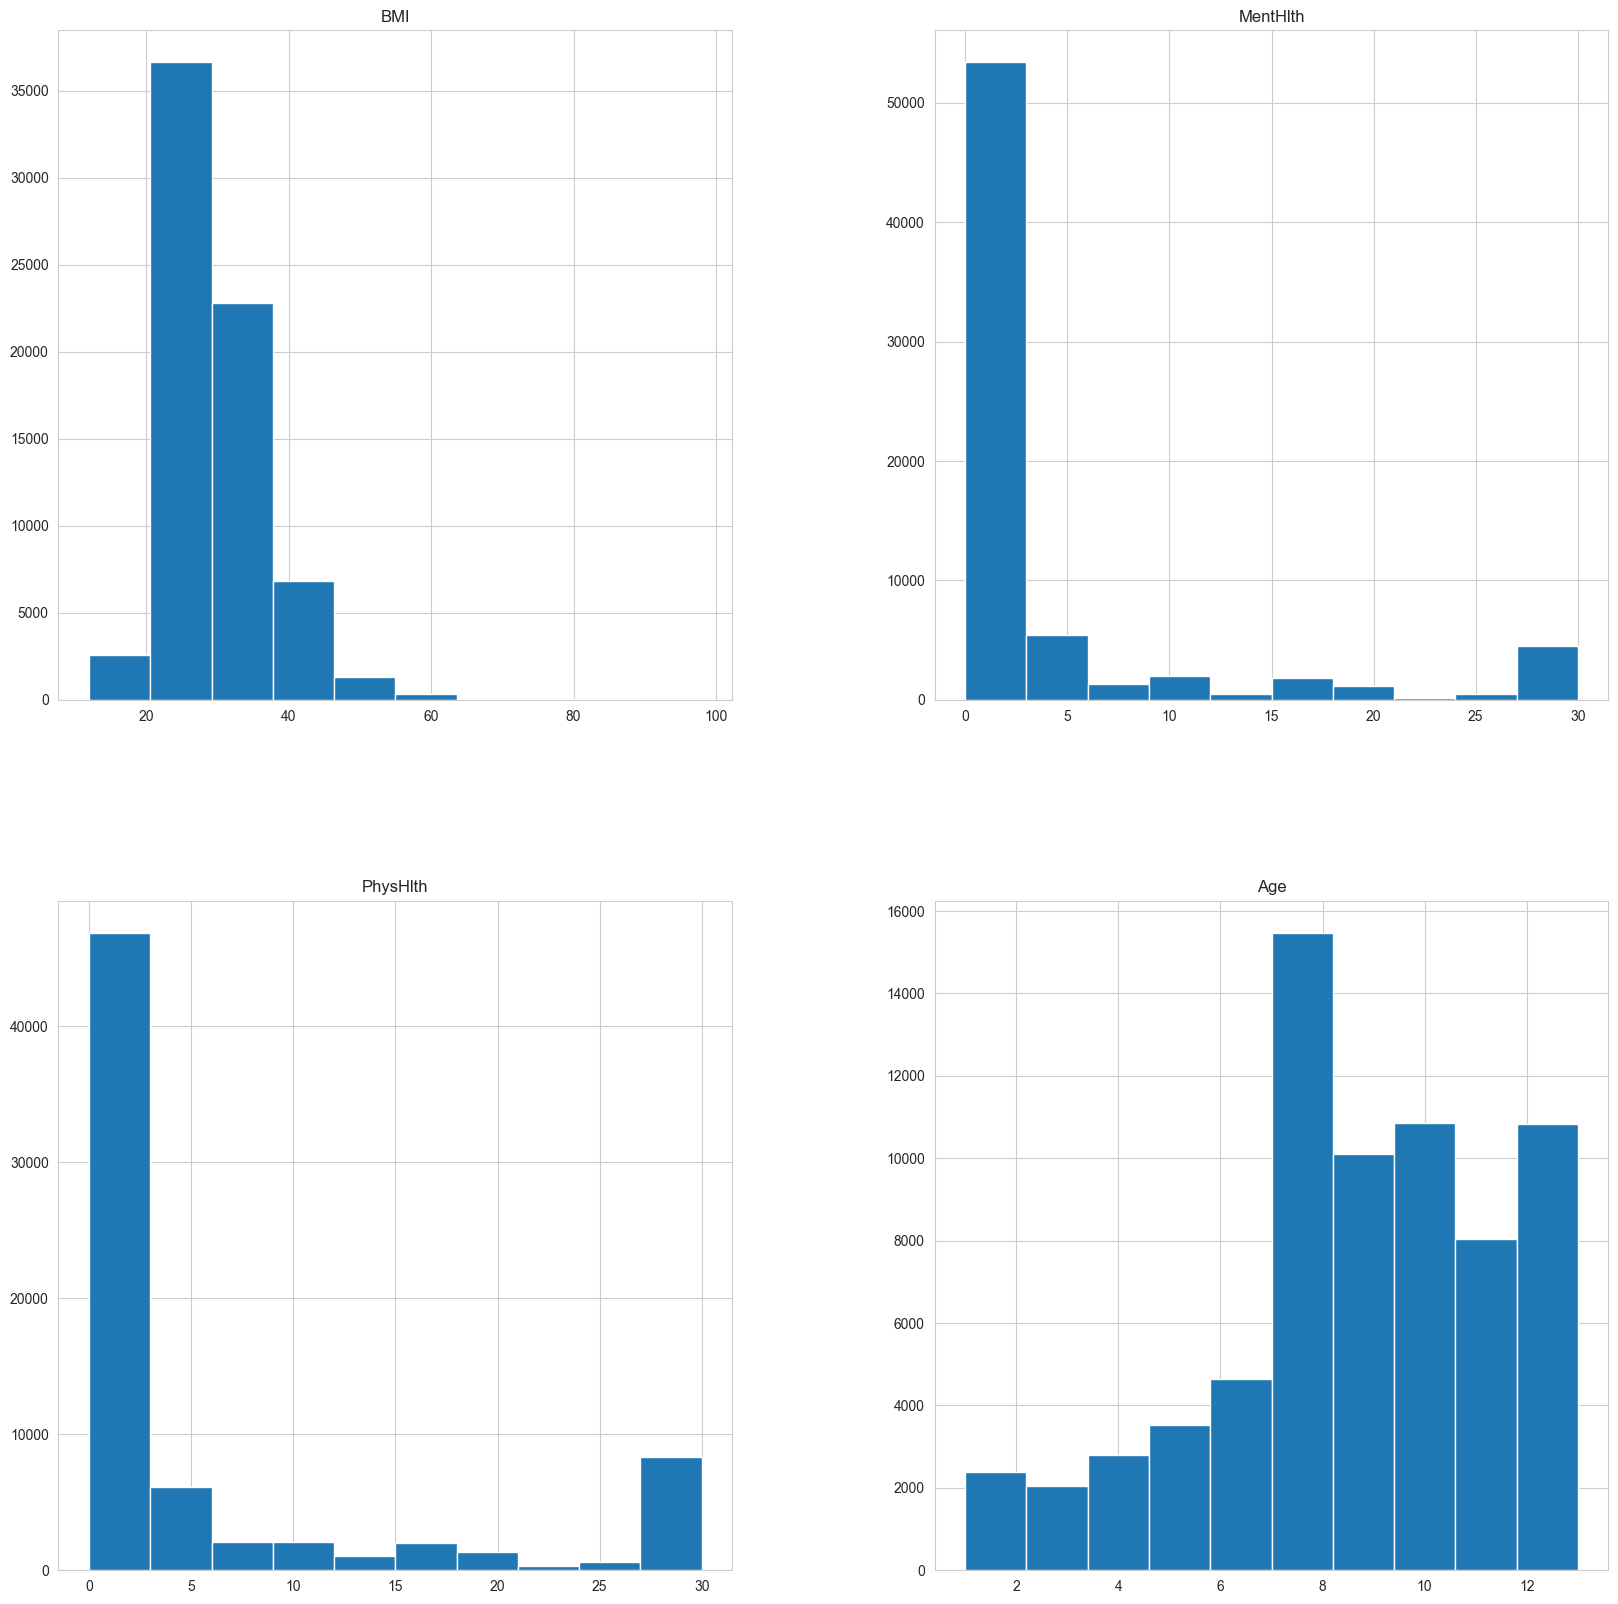

In [ ]:
cont_col = df_train.columns[(df_train.nunique() > 10 )]
df_train[cont_col].describe()
print('Count of continues type attr:' + str(len(cont_col)))
df_train[cont_col].describe()
df_train[cont_col].hist(figsize=(20,20));

Based on the common sense & desc of dataset, 'MentHlth' & 'PhyHlth' should keep being cotinues type because lacking of standard of division.
Howerver, we can divide 'BMI to diffrent parts(replace the continues attributes with the new category one). In addition, considering the new category may don't have ordinal correlation to the targer , **one-hot encoding** should be uesd.
These work will be finished in the part of feature engineering.

## Data-cleaning
    These two datasets have been already cleaned according to the dataset details.

## Data Visualization

Now, we will visualize the binary attributes to find out whether they have unbalanced situation or not.

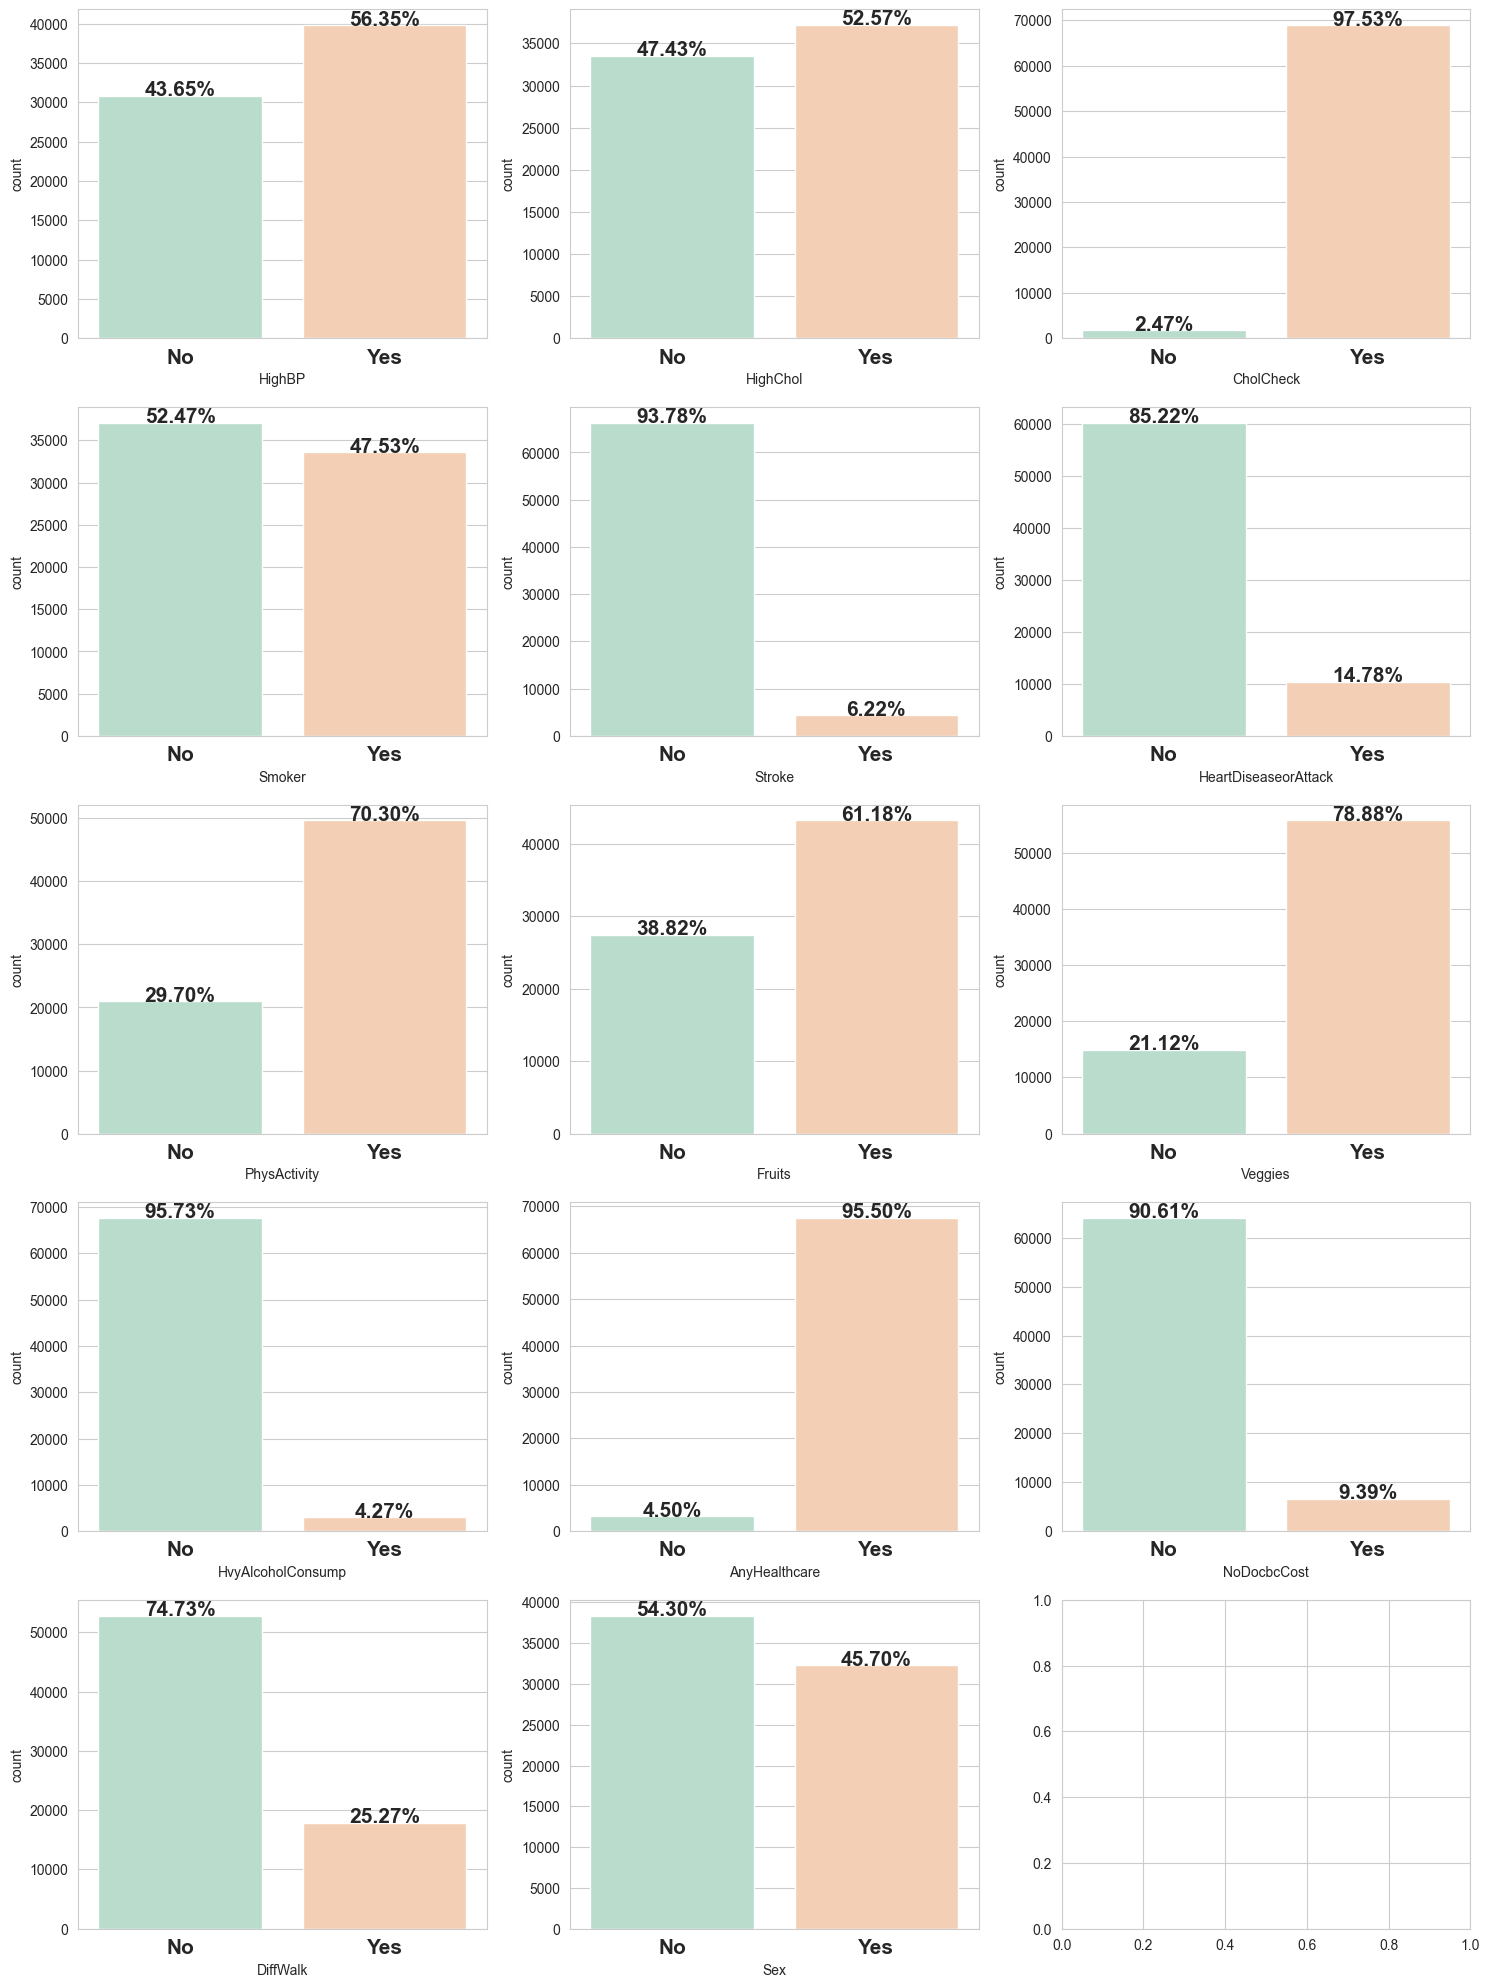

In [30]:
## Create a list of columns to plot
columns = bin_col

# Create a subplot for each column in the list
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
axs = axs.ravel()

for i, column in enumerate(columns):
    sns.countplot(x=df_x_train[column], ax=axs[i],palette='Pastel2')
    axs[i].set_xticklabels(['No', 'Yes'], fontsize=15, fontweight='bold')
    for j in axs[i].patches:
        height = j.get_height()
        axs[i].text(j.get_x() + j.get_width() / 2.,
                height + 20,
                '{:1.2f}%'.format(height / len(df_train) * 100),
                ha="center", fontsize=15,fontweight='bold')

# Show the subplot
plt.tight_layout()
plt.show()

Furthermore, we want to locate more data distribution in more details so that we will visualize these attributes in label's group(Diabetes or None-diabetes)

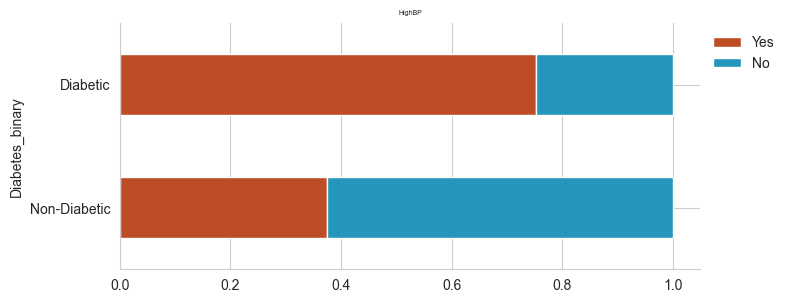

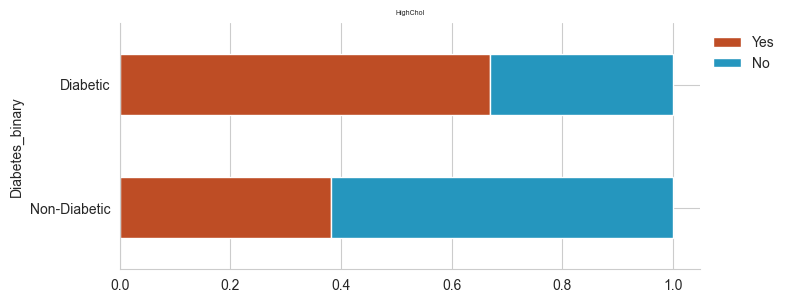

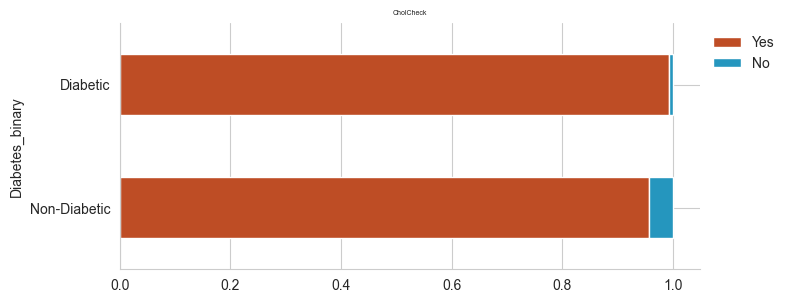

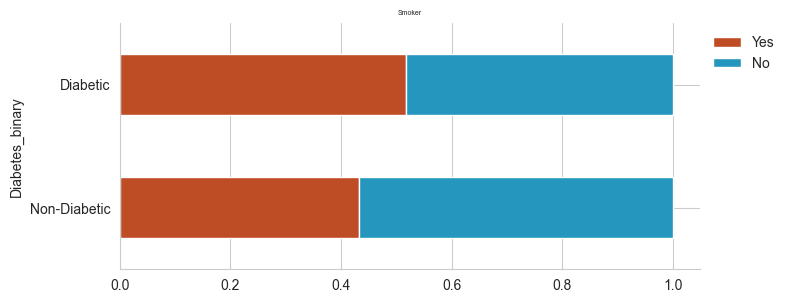

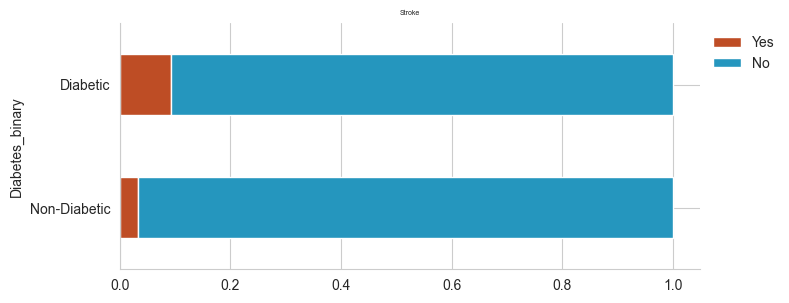

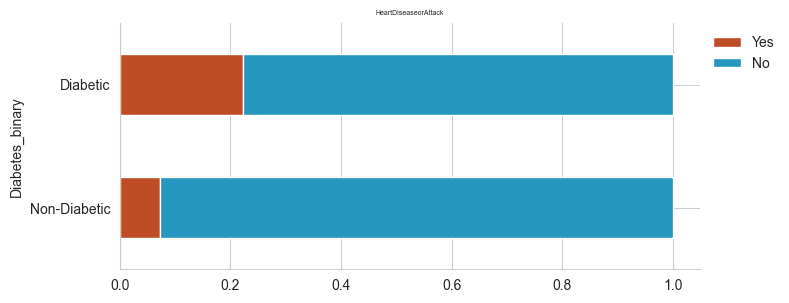

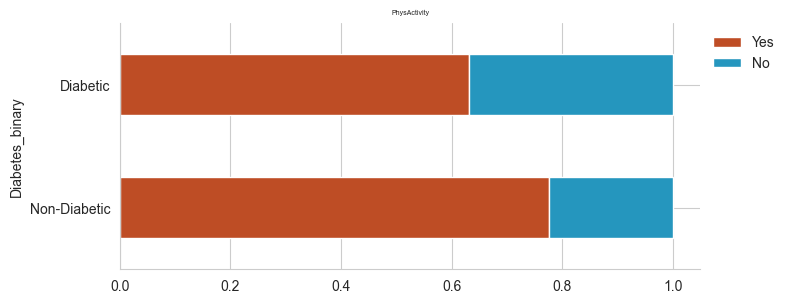

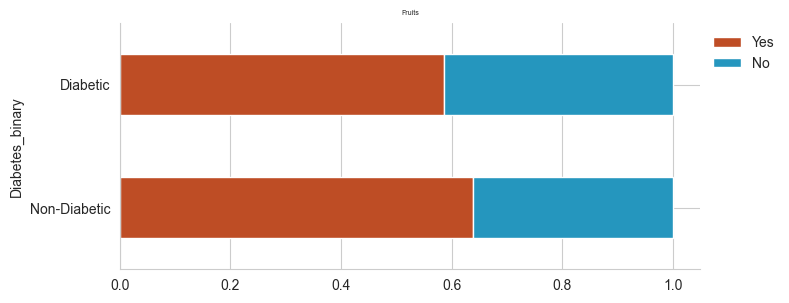

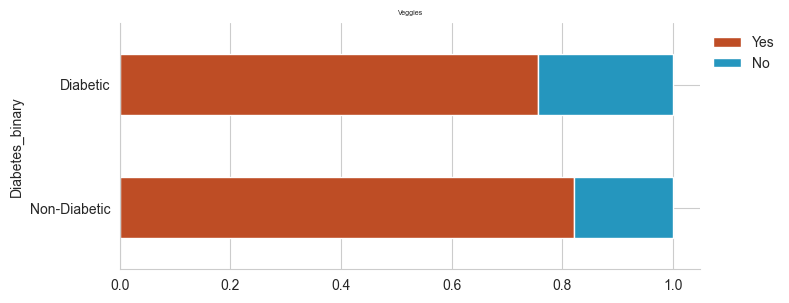

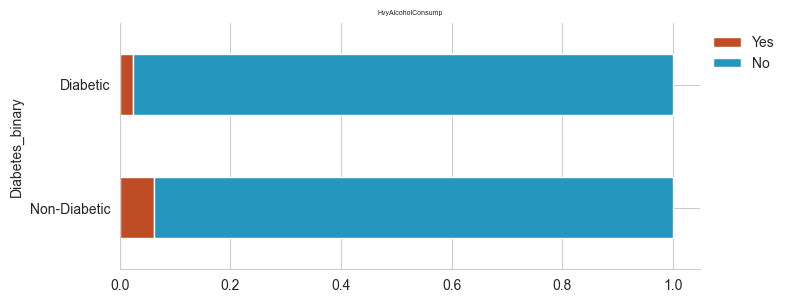

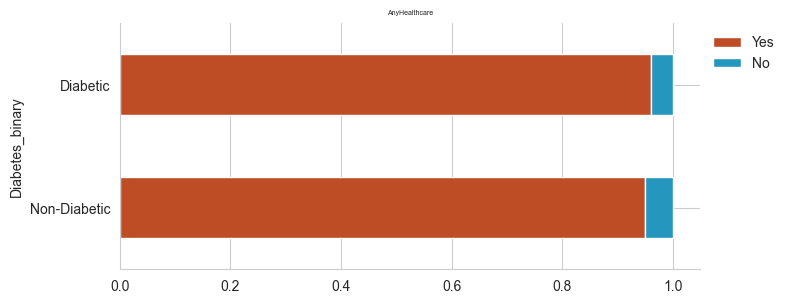

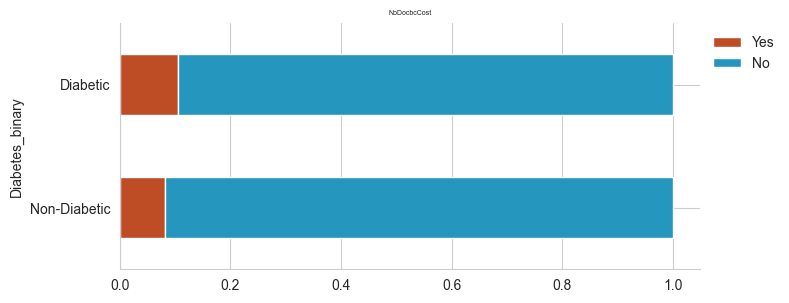

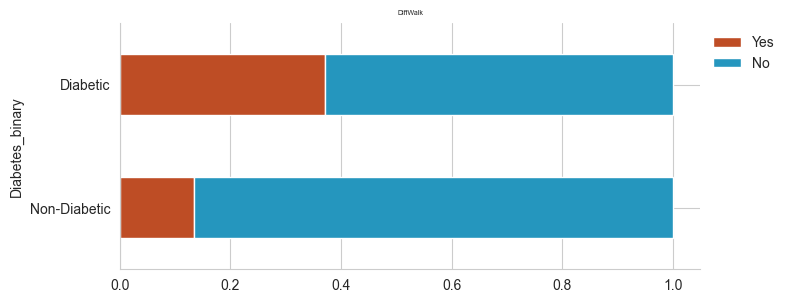

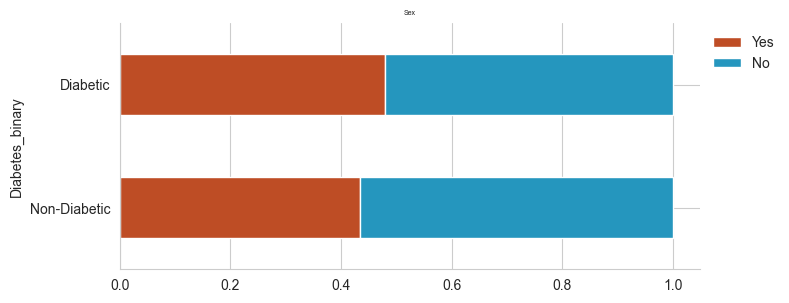

In [32]:
colors = ['#be4d25','#2596be']
def analyse_cat(var):
    (df_train.groupby('Diabetes_binary')[var]
     .value_counts(1)
     .unstack()
     .iloc[:,::-1]
     .plot(kind='barh',stacked=True,figsize=(8, 3), color=colors, alpha=1)
     .spines[['top', 'right']].set_visible(False))
    plt.legend(['Yes', "No"],bbox_to_anchor=(1, 1, 0, 0),shadow=False, frameon=False)
    plt.yticks(ticks=[0,1], labels=['Non-Diabetic', 'Diabetic'])
    plt.tight_layout()
    plt.title(var, fontsize=5)
    plt.show()
for var in df_train[bin_col]:
    analyse_cat(var)

Attributes correlation Matrix

<AxesSubplot: >

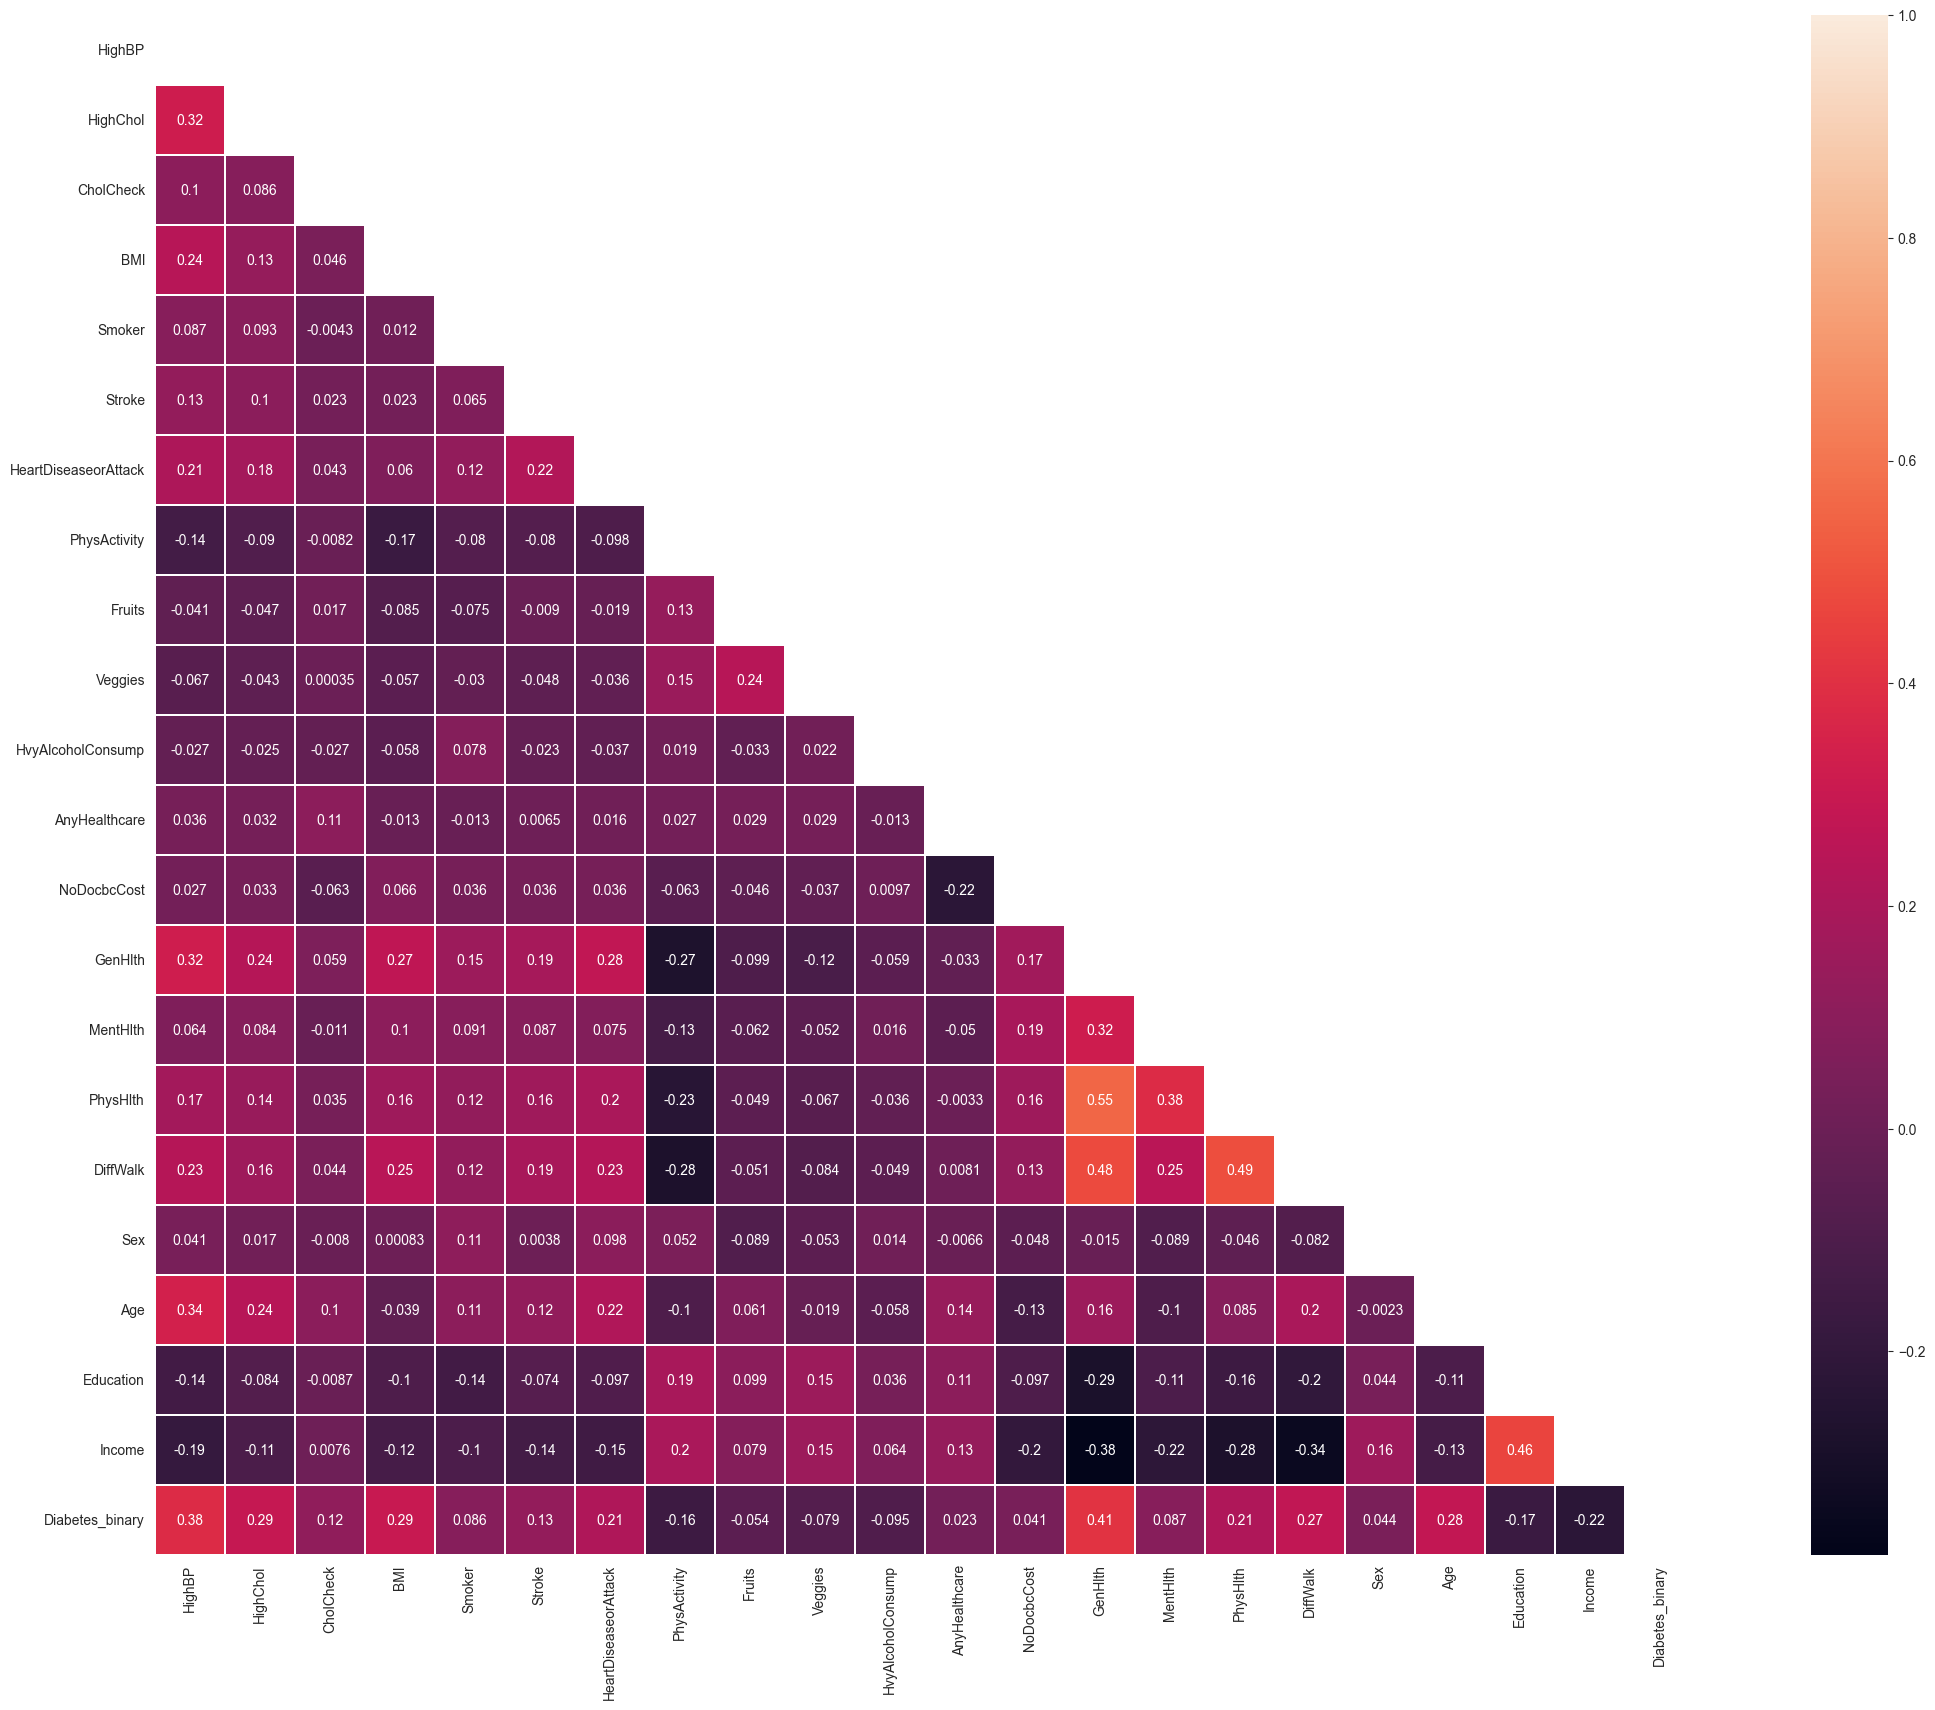

In [34]:
plt.figure(figsize=(30,20))
corr = pd.concat([df_x_train,df_y_train],axis=1).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True  # mask参数用来设置阶梯图
sns.heatmap(corr,linewidths=0.1,mask=mask,vmax=1.0, square=True,linecolor='white', annot=True)

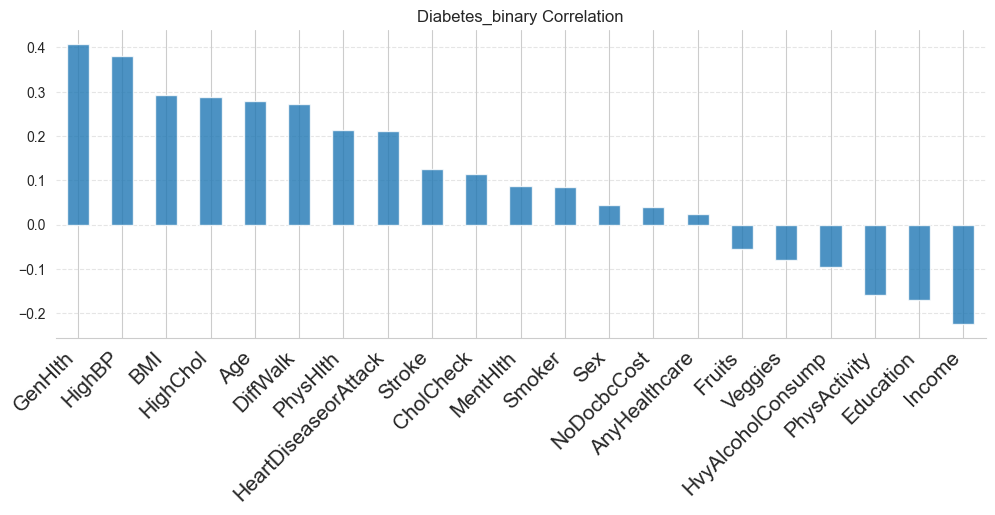

In [36]:
(df_x_train
   .corrwith(df_y_train)
   .sort_values(ascending=False)
   .plot(kind='bar', figsize=(12, 4), title="Diabetes_binary Correlation", alpha=0.8, zorder=3)
   .spines[['top','right', 'left']].set_visible(False)
   )
plt.grid(axis='y', linestyle='--', alpha=.5)
plt.xticks(rotation = 45, ha='right', size=15);

We can find out that there are many attributes have low variance.
For these attributes, we need to set a threshold filtering binary attributes to improve prediction.
This work will be finished in the part of feature selection.

## Data Preprocessing

### 1.One-hot-encoding

Considering the real impaction on the diabetes of our dataset, we find that one attribute in  Categorical Attribute, BMI. Because the effects of BMI on health are not an orderly process, but have unique effects within a specific range. Thus, considering the new category may don't have ordinal correlation to the target , one-hot encoding should be used.

In [37]:
def processDivideBMI(data):
    # Source of BMI standard: https://www.cdc.gov/healthyweight/assessing/index.html
    bins = [0, 18.5, 25, 30, int(max(data['BMI']))]
    labels = ['Underweight', 'Healthyweight', 'Overweight', 'Obese']
    data['BMI_CUT'] = pd.cut(data['BMI'], bins=bins, labels=labels)
    data = data.drop(['BMI'], axis=1)
    return data


df_x_train = processDivideBMI(df_x_train)
df_x_test = processDivideBMI(df_x_test)

#one-hot encoding based on get_dummies
def transformCategoryToValue(data, attributes):
    for attribute in attributes:
        tmpDf = pd.get_dummies(data[attribute], prefix=attribute)
        data = pd.concat([data, tmpDf], axis=1)
        data.drop(attribute, axis=1, inplace=True)
    return data
one_hot_list = ['BMI_CUT']
print(df_x_train.head(5))
df_x_train = transformCategoryToValue(df_x_train,one_hot_list)
df_x_test = transformCategoryToValue(df_x_test,one_hot_list)

   HighBP  HighChol  CholCheck  Smoker  Stroke  HeartDiseaseorAttack  \
0     1.0       0.0        1.0     0.0     0.0                   0.0   
1     1.0       1.0        1.0     1.0     1.0                   0.0   
2     0.0       0.0        1.0     0.0     0.0                   0.0   
3     1.0       1.0        1.0     1.0     0.0                   0.0   
4     0.0       0.0        1.0     1.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  ...  NoDocbcCost  \
0           1.0     0.0      1.0                0.0  ...          0.0   
1           0.0     1.0      0.0                0.0  ...          0.0   
2           1.0     1.0      1.0                0.0  ...          0.0   
3           1.0     1.0      1.0                0.0  ...          0.0   
4           1.0     1.0      1.0                0.0  ...          0.0   

   GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  Income  \
0      3.0       5.0      30.0       0.0  1.0   4.0   

### 2. Feature selection (1) - VarianceThreshold
This feature selection is used to removing features with low variance. Threshold: 0.8*(1-0.8)
We do this selections step before data standardization
Reason:
The VarianceThreshold should typically be applied before data standardization, as the variance calculation can be impacted by the scale and offset of the data. If VarianceThreshold is applied after data standardization, the variance calculation may be inaccurate and lead to the selection of features with higher variance. It is recommended to standardize all features before applying VarianceThreshold to ensure that the variance calculation is consistent across all features and to accurately identify features with lower variance.

In [38]:
def featureSelectionVarianceThreshold(df,df_t,threshold = 0.8):
    """
    This function will filter data according to low variance
    :param df:df_x_train
    :param df_t:df_x_test
    :param threshold:default set 0.8
    :return: filtered df_x_train
    """
    print('Before varianceThreshold-selection:',len(df.columns))
    print(str(df.columns))
    sel = VarianceThreshold(threshold=threshold*(1-threshold))
    tmpNarray = sel.fit_transform(df)
    labels = sel.get_feature_names_out().tolist()
    print(labels)
    print(labels)
    df = pd.DataFrame(
        data=tmpNarray,
        columns=labels
    )
    print('After varianceThreshold-selection:', len(df.columns))
    print(str(df.columns))
    df_t = pd.DataFrame(df_t,columns = labels)
    return df, df_t
df_x_train,df_x_test = featureSelectionVarianceThreshold(df_x_train,df_x_test)

Before varianceThreshold-selection: 24
Index(['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'BMI_CUT_Underweight', 'BMI_CUT_Healthyweight', 'BMI_CUT_Overweight',
       'BMI_CUT_Obese'],
      dtype='object')
['HighBP', 'HighChol', 'Smoker', 'PhysActivity', 'Fruits', 'Veggies', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'BMI_CUT_Healthyweight', 'BMI_CUT_Overweight', 'BMI_CUT_Obese']
['HighBP', 'HighChol', 'Smoker', 'PhysActivity', 'Fruits', 'Veggies', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'BMI_CUT_Healthyweight', 'BMI_CUT_Overweight', 'BMI_CUT_Obese']
After varianceThreshold-selection: 17
Index(['HighBP', 'HighChol', 'Smoker', 'PhysActivity', 'Fruits', 'Veggies',
      

### 3.Data Standardization
For distance-based models, standardization is performed to prevent features with wider ranges from dominating the distance metric.

In [39]:
df_st_x_train = scale(df_x_train)
df_st_x_train = pd.DataFrame(data=df_st_x_train,columns=df_x_train.columns)

df_st_x_test = scale(df_x_test)
df_st_x_test = pd.DataFrame(data=df_st_x_test,columns=df_x_test.columns)

### 4.Feature selection(2) Link attributes & label


#### 5.1 Filter Model - f_classif (Because of  standarization ,X has negative values, which chi2 refuses to accept)

To find out the best features which influent our label, we firstly chooss all features and print their scores, then judge by their contribution to label.

In [40]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(df_st_x_train,df_y_train)
mask = fs.get_support(indices=True)
selected_col_names = df_st_x_train.columns[mask].tolist()

Text(0.5, 1.0, 'F-class')

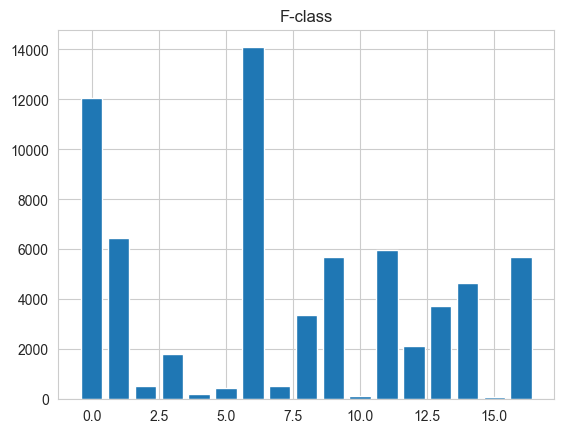

In [41]:

# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('F-class')


In [42]:
# what are scores for the features
def selectByScore(fs,X,score = 1000):
    """
    select features by ranking selectKBest features score
    :param fs: fitted selectKBest by X
    :param score: default set as 1000
    :return: None
    """
    mask = fs.get_support(indices=True)
    selected_col_names = X.columns[mask].tolist()
    print('Here are the selected features & its score with score threshold:%f'%score)
    cnt=0
    for i in range(len(fs.scores_)):
        if fs.scores_[i] > 1000:
            print('Feature %d - %s: %f '% (i,selected_col_names[i],fs.scores_[i]))
            cnt = cnt+1
    print('Selected features count:%d'%cnt)

In [43]:
selectByScore(fs,df_st_x_train,1000)

Here are the selected features & its score with score threshold:1000.000000
Feature 0 - HighBP: 12041.980062 
Feature 1 - HighChol: 6452.511956 
Feature 3 - PhysActivity: 1825.562920 
Feature 6 - GenHlth: 14085.156108 
Feature 8 - PhysHlth: 3362.232049 
Feature 9 - DiffWalk: 5676.789827 
Feature 11 - Age: 5954.920141 
Feature 12 - Education: 2116.008112 
Feature 13 - Income: 3750.084957 
Feature 14 - BMI_CUT_Healthyweight: 4668.633863 
Feature 16 - BMI_CUT_Obese: 5675.445897 
Selected features count:11


Then we set param in the SelectKBest as 11.

In [44]:
fs_flass = SelectKBest(score_func=f_classif, k=11).fit(df_st_x_train,df_y_train)
x_train_fclass = fs_flass.transform(df_st_x_train)
x_test_fclass = fs_flass.transform(df_st_x_test)
mask = fs_flass.get_support(indices=True)
selected_col_names = df_st_x_train.columns[mask].tolist()
print("Filter-selectKBest-f_classif Feature selection result——————————————————————————————————————————————————")
print("Feature Num : %d" % len(selected_col_names))
print("Feature Columns : %s" % selected_col_names)

Filter-selectKBest-f_classif Feature selection result——————————————————————————————————————————————————
Feature Num : 11
Feature Columns : ['HighBP', 'HighChol', 'PhysActivity', 'GenHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education', 'Income', 'BMI_CUT_Healthyweight', 'BMI_CUT_Obese']


### 5.2 Wrapper-RFECV(Recursive Feature Elimination CV) Estimator: LogicRegression
RFECV can automatically decide the number of features.

In [45]:
# The reason we choose LogisticRegression as the estimator is to speed-up feature selection of RFECV.
rfecv = RFECV(estimator=LogisticRegression(),          # 学习器
              step=1,                 # 移除特征个数
              cv=StratifiedKFold(2),  # 交叉验证次数
              scoring='accuracy',     # 学习器的评价标准
              verbose = 1,
              n_jobs = 1
              ).fit(df_st_x_train, df_y_train)
x_train_rfecv = rfecv.transform(df_st_x_train)
x_test_rfecv = rfecv.transform(df_st_x_test)


Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitt

In [46]:
print("RFECV Feature selection result——————————————————————————————————————————————————")
print("Feature Num : %d" % rfecv.n_features_)
print("Feature Columns : %s" % list(rfecv.get_feature_names_out()))

RFECV Feature selection result——————————————————————————————————————————————————
Feature Num : 14
Feature Columns : ['HighBP', 'HighChol', 'Veggies', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income', 'BMI_CUT_Healthyweight', 'BMI_CUT_Overweight', 'BMI_CUT_Obese']


#### 5.3 Model selection


In [47]:
def modelSelection(X,Y,test_size=0.1):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=test_size)
    # return fitted bestModel
    # The model is trained by training dataset & selected based on the performace on the test dataset
    modelDic = {
        'LogisticRegression':LogisticRegression(),
        # 'Perceptron':Perceptron(),
        # 'SGDClassifier':SGDClassifier(),
        'KNeighborsClassifier':KNeighborsClassifier(),
        'DecisionTreeClassifier':DecisionTreeClassifier(),
        'RandomForestClassifier':RandomForestClassifier(),
        'GaussianNB':GaussianNB(),
        'GradientBoostingClassifier':GradientBoostingClassifier(),
        'XGBClassifier':XGBClassifier()
    }
    grid_search_param = {
        'LogisticRegression':{ 'C':[0.001, 0.01, 0.1, 1,10]},
        # 'Perceptron':{'alpha':[0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]},
        # 'SGDClassifier':{'alpha':[0.0001,0.001, 0.01, 0.1, 1, 10]},
        'KNeighborsClassifier':[
             {
                'weights':['uniform'],
                 'n_neighbors':[i for i in range(1,11)]
            },
            {
                  'weights':['distance'],
                  'n_neighbors':[i for i in range(1,11)],
                  'p':[i for i in range(1,6)]
             }
         ],
        'DecisionTreeClassifier':{
            'criterion':['gini'],'max_depth':[30,50,60,100],
            'min_samples_leaf':[2,3,5,10],
            'min_impurity_decrease':[0.1,0.2,0.5]
        },
        'RandomForestClassifier':{
            "n_estimators": [10, 15, 20],
            "criterion": ["gini", "entropy"],
            "min_samples_leaf": [2, 4, 6],
        },
        'GaussianNB':{
            'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
        },
        'GradientBoostingClassifier':{'learning_rate': [0.01, 0.1, 1.0],
              'max_depth': [3, 5, 7],
              'n_estimators': [50, 100, 200]
        },
        'XGBClassifier':{'n_estimators': np.linspace(10, 20, 1, dtype=int)}
    }
    bestModelName = ''
    bestScore = 0
    print('Models score without CV:')
    for modelName in modelDic.keys():
        tmpModel = modelDic[modelName]
        tmpModel.fit(X_train, Y_train)
        y_pred = tmpModel.predict(X_test)
        score = roc_auc_score(Y_test, y_pred)
        print('---------------'+modelName+'---------------')
        print(modelName + 'AUC:', score)
        print(classification_report(Y_test, y_pred))
        disp = ConfusionMatrixDisplay.from_estimator(tmpModel, X_test, Y_test,display_labels=['0','1'],values_format = '.0f',cmap=plt.cm.Blues)
        disp.ax_.set_title(modelName)
        np.set_printoptions(precision=1)
        print('confusion_matrix:')
        print(disp.confusion_matrix)
        plt.show()
        if score > bestScore:
            bestScore = score
            bestModel = tmpModel
            bestModelName = modelName

    print('Models score with CV:')
    for modelName in modelDic.keys():
        grid_cv_param = grid_search_param[modelName]
        tmpModel = GridSearchCV(modelDic[modelName], grid_cv_param, cv=5,  scoring='roc_auc')
        tmpModel.fit(X_train, Y_train)
        # score = tmpModel.score(X_test,Y_test)
        y_pred = tmpModel.predict(X_test)
        score = roc_auc_score(Y_test, y_pred)
        print('---------------'+modelName+'---------------')
        print(modelName + 'AUC:', score)
        print(classification_report(Y_test, y_pred))
        disp = ConfusionMatrixDisplay.from_estimator(tmpModel, X_test, Y_test,display_labels=['0','1'],values_format = '.0f',cmap=plt.cm.Blues)
        disp.ax_.set_title(modelName+'with CV')
        np.set_printoptions(precision=1)
        print('confusion_matrix:')
        print(disp.confusion_matrix)
        plt.show()
        if score > bestScore:
            bestScore = score
            bestModel = tmpModel
            bestModelName = modelName
    print('BestModel is ' + bestModelName + ', score is ' + str(bestScore))
    return bestModel




#### 5.3.1 Filter model selection result

Models score without CV:
---------------LogisticRegression---------------
LogisticRegressionAUC: 0.738668548213107
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.73      3546
         1.0       0.73      0.76      0.74      3524

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070

confusion_matrix:
[[2557  989]
 [ 859 2665]]


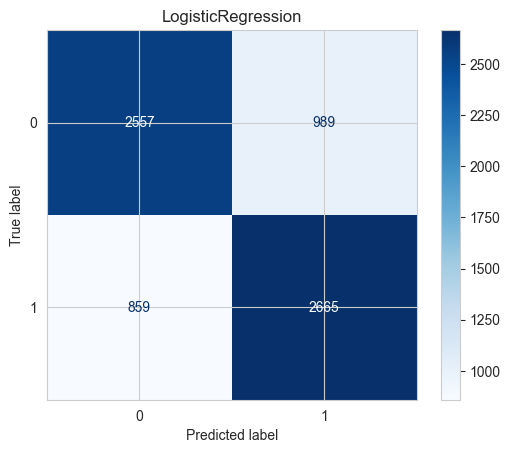

---------------KNeighborsClassifier---------------
KNeighborsClassifierAUC: 0.7091106956216114
              precision    recall  f1-score   support

         0.0       0.72      0.69      0.70      3546
         1.0       0.70      0.73      0.71      3524

    accuracy                           0.71      7070
   macro avg       0.71      0.71      0.71      7070
weighted avg       0.71      0.71      0.71      7070

confusion_matrix:
[[2448 1098]
 [ 959 2565]]


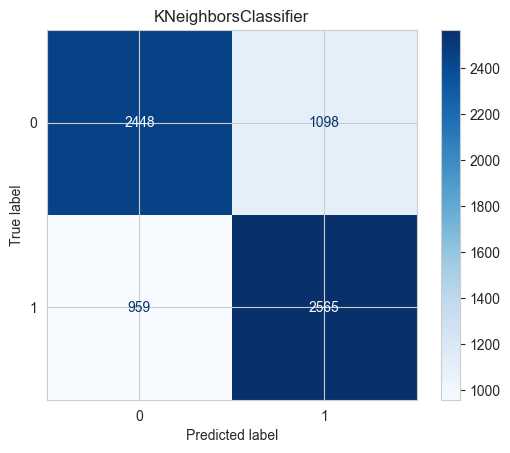

---------------DecisionTreeClassifier---------------
DecisionTreeClassifierAUC: 0.6674558726463864
              precision    recall  f1-score   support

         0.0       0.65      0.72      0.68      3546
         1.0       0.68      0.62      0.65      3524

    accuracy                           0.67      7070
   macro avg       0.67      0.67      0.67      7070
weighted avg       0.67      0.67      0.67      7070

confusion_matrix:
[[2542 1004]
 [1346 2178]]


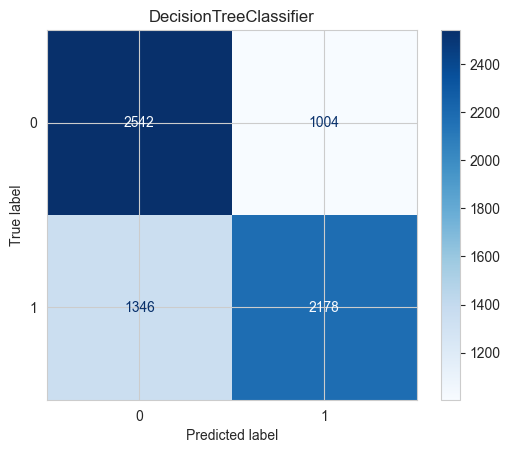

---------------RandomForestClassifier---------------
RandomForestClassifierAUC: 0.7052542936582474
              precision    recall  f1-score   support

         0.0       0.71      0.70      0.70      3546
         1.0       0.70      0.71      0.71      3524

    accuracy                           0.71      7070
   macro avg       0.71      0.71      0.71      7070
weighted avg       0.71      0.71      0.71      7070

confusion_matrix:
[[2477 1069]
 [1015 2509]]


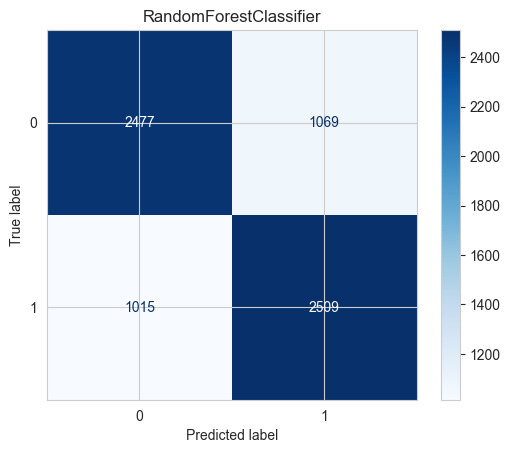

---------------GaussianNB---------------
GaussianNBAUC: 0.7204149389281651
              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73      3546
         1.0       0.73      0.69      0.71      3524

    accuracy                           0.72      7070
   macro avg       0.72      0.72      0.72      7070
weighted avg       0.72      0.72      0.72      7070

confusion_matrix:
[[2662  884]
 [1092 2432]]


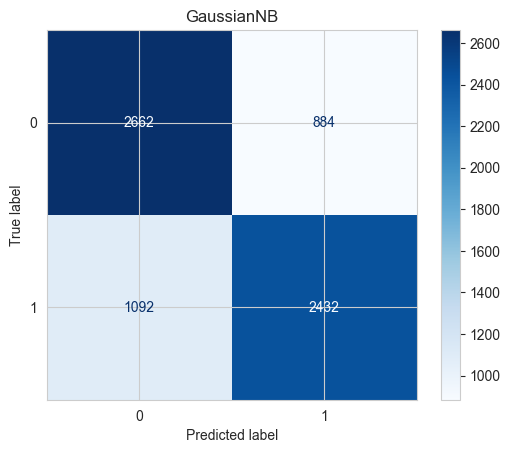

---------------GradientBoostingClassifier---------------
GradientBoostingClassifierAUC: 0.7380119435625696
              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73      3546
         1.0       0.72      0.77      0.75      3524

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070

confusion_matrix:
[[2497 1049]
 [ 804 2720]]


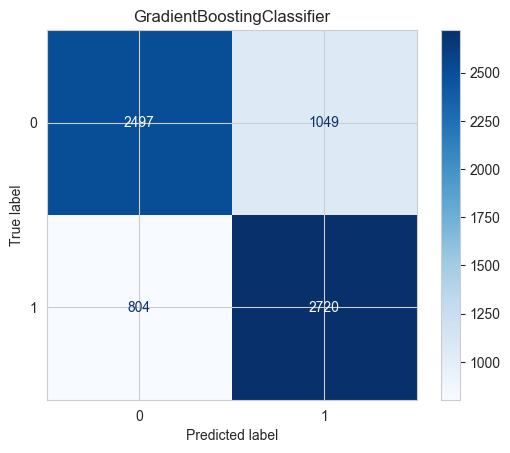

---------------XGBClassifier---------------
XGBClassifierAUC: 0.7365878196916416
              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73      3546
         1.0       0.72      0.77      0.74      3524

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070

confusion_matrix:
[[2503 1043]
 [ 820 2704]]


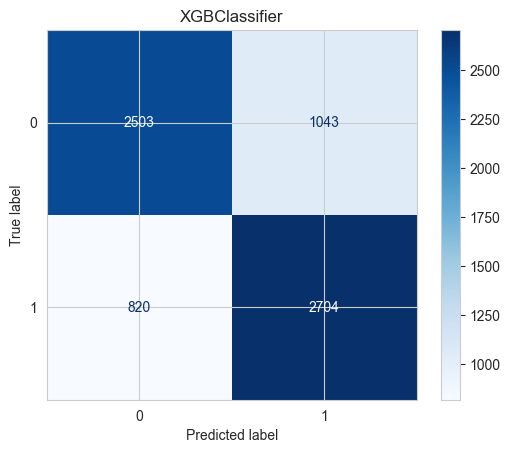

Models score with CV:
---------------LogisticRegression---------------
LogisticRegressionAUC: 0.7385275442649964
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.73      3546
         1.0       0.73      0.76      0.74      3524

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070

confusion_matrix:
[[2556  990]
 [ 859 2665]]


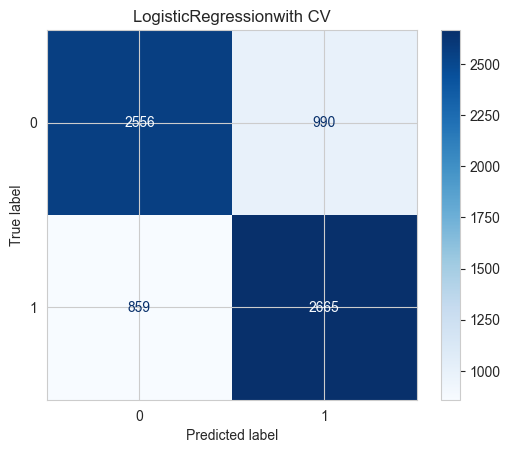

---------------KNeighborsClassifier---------------
KNeighborsClassifierAUC: 0.7157802944021593
              precision    recall  f1-score   support

         0.0       0.71      0.74      0.72      3546
         1.0       0.72      0.70      0.71      3524

    accuracy                           0.72      7070
   macro avg       0.72      0.72      0.72      7070
weighted avg       0.72      0.72      0.72      7070

confusion_matrix:
[[2608  938]
 [1071 2453]]


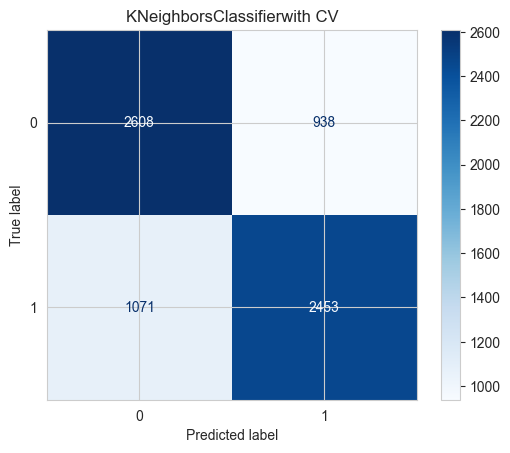

---------------DecisionTreeClassifier---------------
DecisionTreeClassifierAUC: 0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      3546
         1.0       0.50      1.00      0.67      3524

    accuracy                           0.50      7070
   macro avg       0.25      0.50      0.33      7070
weighted avg       0.25      0.50      0.33      7070

confusion_matrix:
[[   0 3546]
 [   0 3524]]


/Users/usyun/miniforge3/envs/eda_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/usyun/miniforge3/envs/eda_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/usyun/miniforge3/envs/eda_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

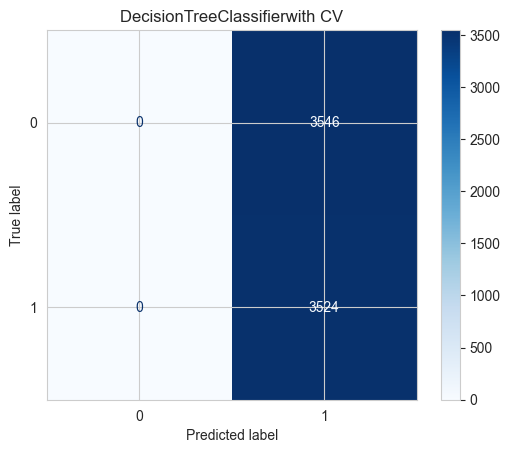

---------------RandomForestClassifier---------------
RandomForestClassifierAUC: 0.7351751393874443
              precision    recall  f1-score   support

         0.0       0.75      0.70      0.73      3546
         1.0       0.72      0.77      0.74      3524

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.73      7070
weighted avg       0.74      0.74      0.73      7070

confusion_matrix:
[[2496 1050]
 [ 823 2701]]


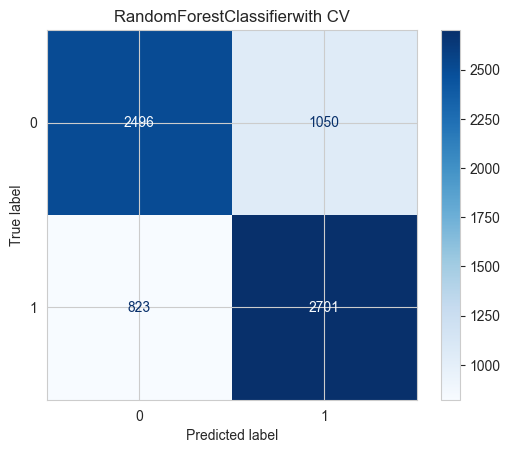

---------------GaussianNB---------------
GaussianNBAUC: 0.7201302902088523
              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73      3546
         1.0       0.73      0.69      0.71      3524

    accuracy                           0.72      7070
   macro avg       0.72      0.72      0.72      7070
weighted avg       0.72      0.72      0.72      7070

confusion_matrix:
[[2663  883]
 [1095 2429]]


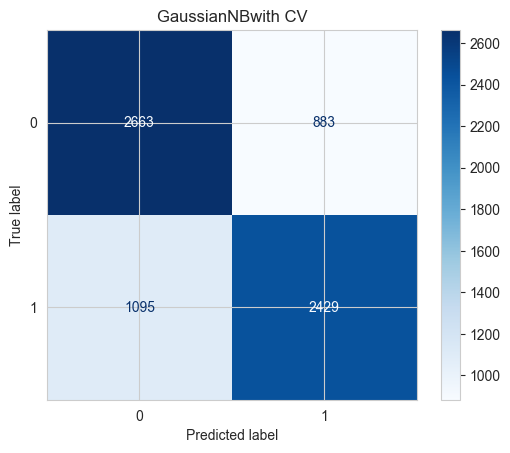

---------------GradientBoostingClassifier---------------
GradientBoostingClassifierAUC: 0.7380119435625696
              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73      3546
         1.0       0.72      0.77      0.75      3524

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070

confusion_matrix:
[[2497 1049]
 [ 804 2720]]


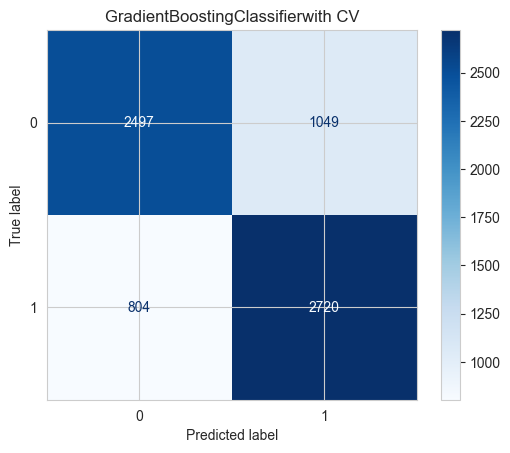

---------------XGBClassifier---------------
XGBClassifierAUC: 0.739978956641206
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      3546
         1.0       0.73      0.77      0.75      3524

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070

confusion_matrix:
[[2519 1027]
 [ 812 2712]]


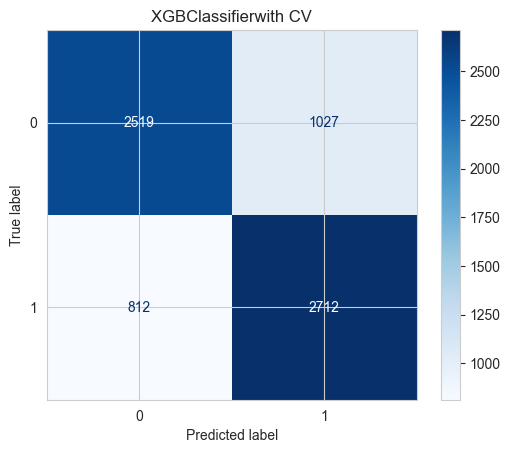

BestModel is XGBClassifier, score is 0.739978956641206


In [48]:
best_model_fclass = modelSelection(x_train_fclass,df_y_train)

#### 5.2.1 RFECV Model selection


Models score without CV:
---------------LogisticRegression---------------
LogisticRegressionAUC: 0.740663852931171
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.73      3523
         1.0       0.73      0.76      0.75      3547

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070

confusion_matrix:
[[2535  988]
 [ 845 2702]]


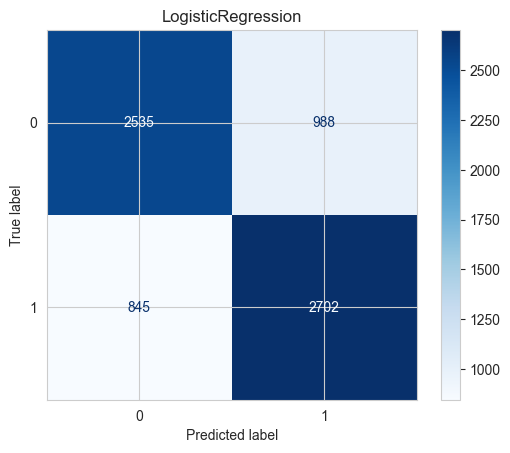

---------------KNeighborsClassifier---------------
KNeighborsClassifierAUC: 0.7053918744604808
              precision    recall  f1-score   support

         0.0       0.72      0.67      0.69      3523
         1.0       0.69      0.74      0.72      3547

    accuracy                           0.71      7070
   macro avg       0.71      0.71      0.71      7070
weighted avg       0.71      0.71      0.71      7070

confusion_matrix:
[[2356 1167]
 [ 915 2632]]


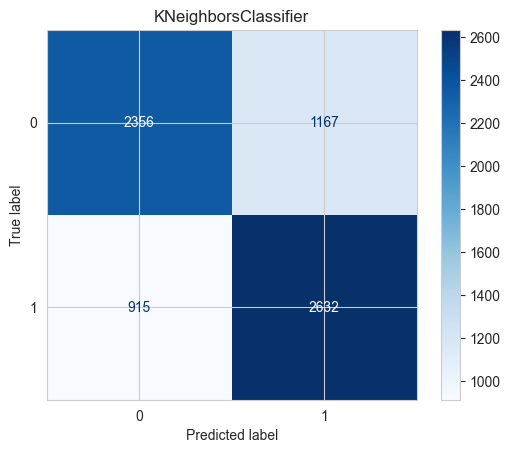

---------------DecisionTreeClassifier---------------
DecisionTreeClassifierAUC: 0.6622042142652563
              precision    recall  f1-score   support

         0.0       0.65      0.69      0.67      3523
         1.0       0.68      0.63      0.65      3547

    accuracy                           0.66      7070
   macro avg       0.66      0.66      0.66      7070
weighted avg       0.66      0.66      0.66      7070

confusion_matrix:
[[2448 1075]
 [1314 2233]]


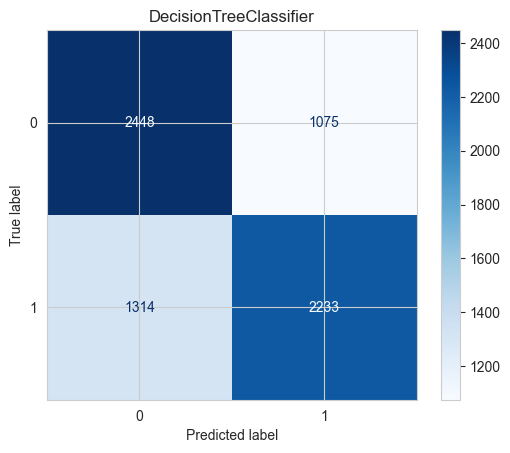

---------------RandomForestClassifier---------------
RandomForestClassifierAUC: 0.7131958011475759
              precision    recall  f1-score   support

         0.0       0.73      0.68      0.70      3523
         1.0       0.70      0.74      0.72      3547

    accuracy                           0.71      7070
   macro avg       0.71      0.71      0.71      7070
weighted avg       0.71      0.71      0.71      7070

confusion_matrix:
[[2409 1114]
 [ 913 2634]]


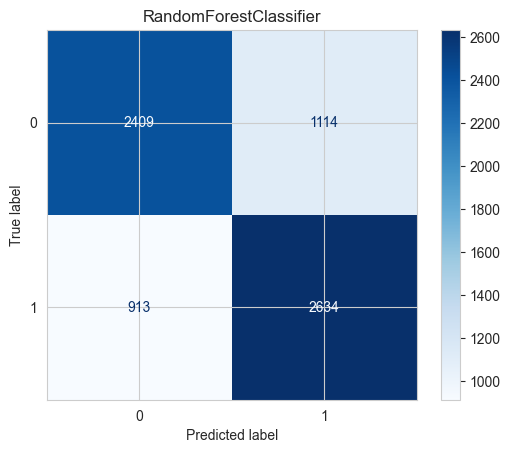

---------------GaussianNB---------------
GaussianNBAUC: 0.7200487096714561
              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73      3523
         1.0       0.74      0.69      0.71      3547

    accuracy                           0.72      7070
   macro avg       0.72      0.72      0.72      7070
weighted avg       0.72      0.72      0.72      7070

confusion_matrix:
[[2646  877]
 [1103 2444]]


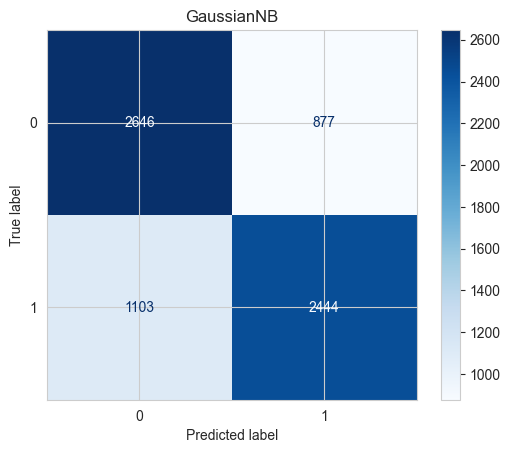

---------------GradientBoostingClassifier---------------
GradientBoostingClassifierAUC: 0.7444103475321584
              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73      3523
         1.0       0.73      0.79      0.76      3547

    accuracy                           0.74      7070
   macro avg       0.75      0.74      0.74      7070
weighted avg       0.75      0.74      0.74      7070

confusion_matrix:
[[2473 1050]
 [ 756 2791]]


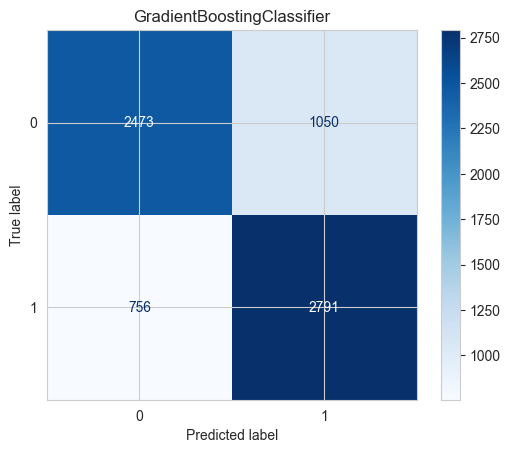

---------------XGBClassifier---------------
XGBClassifierAUC: 0.7425806938991513
              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73      3523
         1.0       0.73      0.78      0.75      3547

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070

confusion_matrix:
[[2476 1047]
 [ 772 2775]]


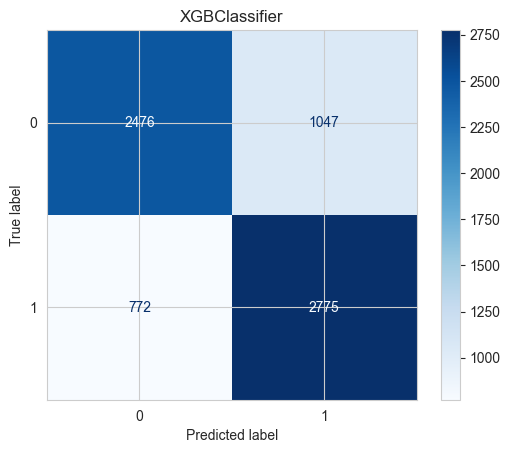

Models score with CV:
---------------LogisticRegression---------------
LogisticRegressionAUC: 0.740663852931171
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.73      3523
         1.0       0.73      0.76      0.75      3547

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070

confusion_matrix:
[[2535  988]
 [ 845 2702]]


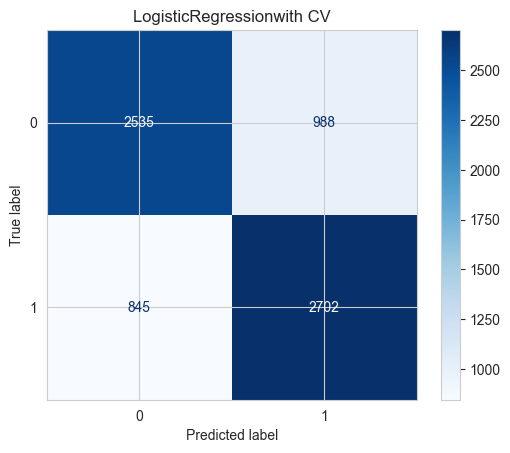

---------------KNeighborsClassifier---------------
KNeighborsClassifierAUC: 0.7195384296884759
              precision    recall  f1-score   support

         0.0       0.72      0.73      0.72      3523
         1.0       0.72      0.71      0.72      3547

    accuracy                           0.72      7070
   macro avg       0.72      0.72      0.72      7070
weighted avg       0.72      0.72      0.72      7070

confusion_matrix:
[[2555  968]
 [1015 2532]]


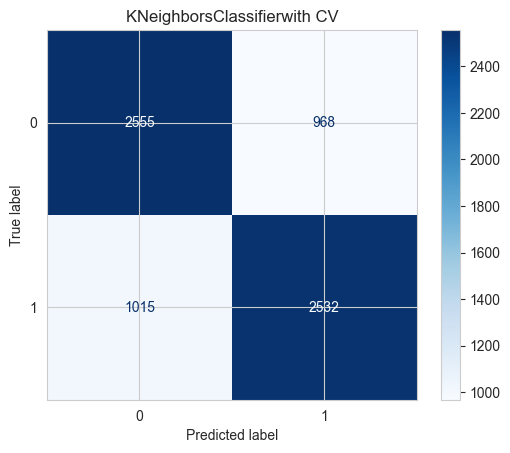

---------------DecisionTreeClassifier---------------
DecisionTreeClassifierAUC: 0.5
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      3523
         1.0       0.00      0.00      0.00      3547

    accuracy                           0.50      7070
   macro avg       0.25      0.50      0.33      7070
weighted avg       0.25      0.50      0.33      7070

confusion_matrix:
[[3523    0]
 [3547    0]]


/Users/usyun/miniforge3/envs/eda_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/usyun/miniforge3/envs/eda_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/usyun/miniforge3/envs/eda_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

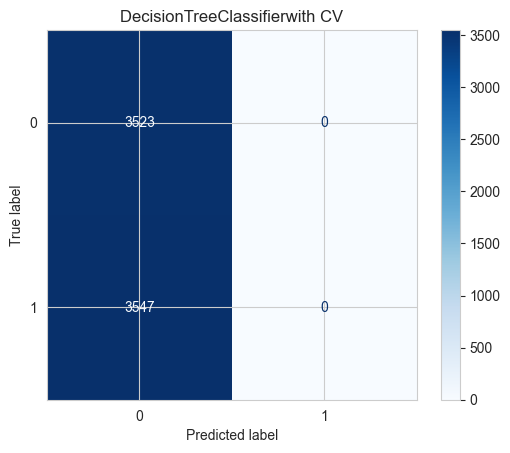

---------------RandomForestClassifier---------------
RandomForestClassifierAUC: 0.741859547805428
              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73      3523
         1.0       0.72      0.79      0.75      3547

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070

confusion_matrix:
[[2459 1064]
 [ 760 2787]]


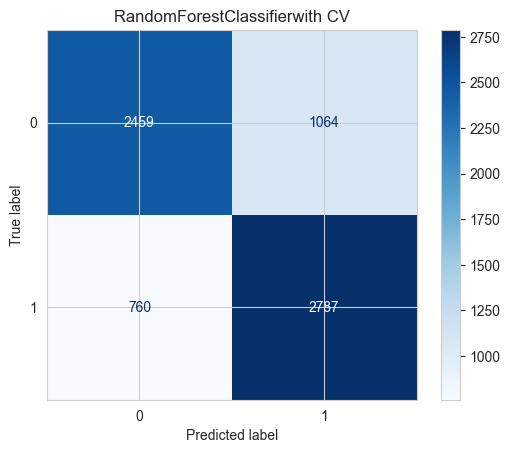

---------------GaussianNB---------------
GaussianNBAUC: 0.7203315983627185
              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73      3523
         1.0       0.74      0.69      0.71      3547

    accuracy                           0.72      7070
   macro avg       0.72      0.72      0.72      7070
weighted avg       0.72      0.72      0.72      7070

confusion_matrix:
[[2647  876]
 [1102 2445]]


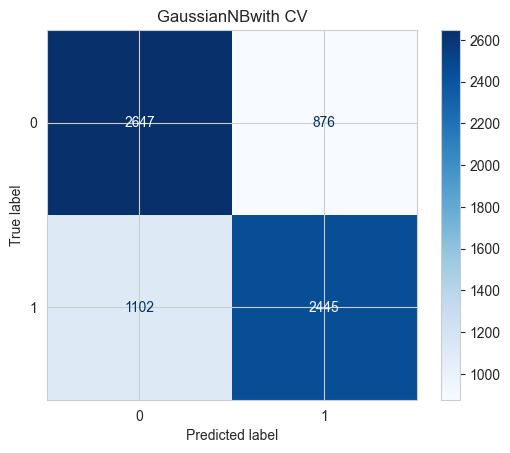

---------------GradientBoostingClassifier---------------
GradientBoostingClassifierAUC: 0.7444103475321584
              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73      3523
         1.0       0.73      0.79      0.76      3547

    accuracy                           0.74      7070
   macro avg       0.75      0.74      0.74      7070
weighted avg       0.75      0.74      0.74      7070

confusion_matrix:
[[2473 1050]
 [ 756 2791]]


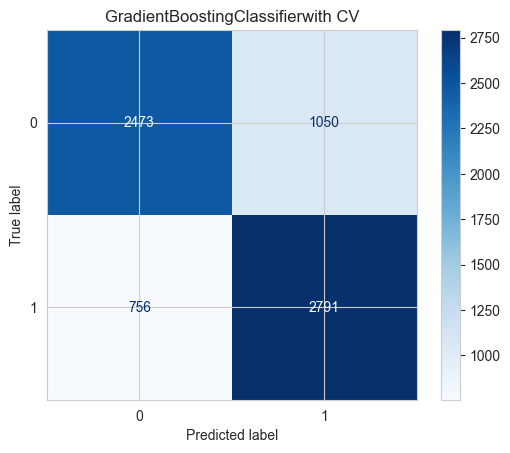

---------------XGBClassifier---------------
XGBClassifierAUC: 0.742432047295468
              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73      3523
         1.0       0.73      0.78      0.75      3547

    accuracy                           0.74      7070
   macro avg       0.74      0.74      0.74      7070
weighted avg       0.74      0.74      0.74      7070

confusion_matrix:
[[2468 1055]
 [ 765 2782]]


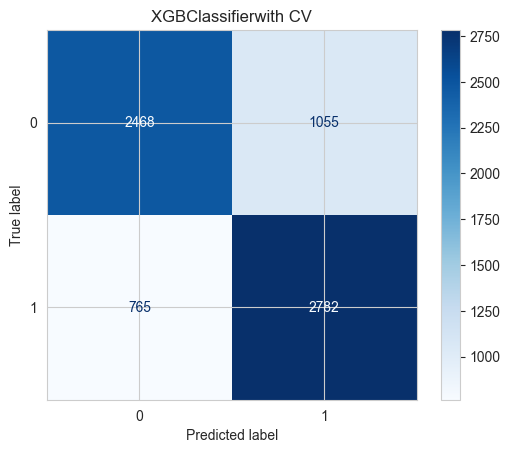

BestModel is GradientBoostingClassifier, score is 0.7444103475321584


In [49]:
best_model_RFECV = modelSelection(x_train_rfecv,df_y_train)

## ROC-AUC of selected models after feature selection.

Text(0.5, 1.0, 'Prediction result on 70k dataset')

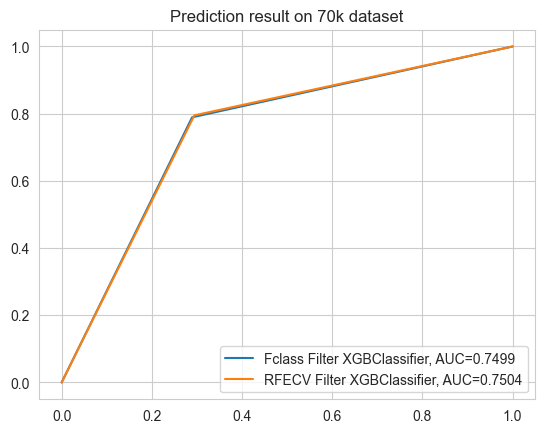

In [52]:
y_pred = best_model_fclass.predict(x_train_fclass)
fpr, tpr, _ = roc_curve(df_y_train, y_pred)
auc = round(roc_auc_score(df_y_train, y_pred), 4)
plt.plot(fpr,tpr,label="Fclass Filter XGBClassifier, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve

y_pred = best_model_RFECV.predict(x_train_rfecv)
fpr, tpr, _ = roc_curve(df_y_train, y_pred)
auc = round(roc_auc_score(df_y_train, y_pred), 4)
plt.plot(fpr,tpr,label="RFECV Filter XGBClassifier, AUC="+str(auc))
plt.legend()
plt.title('Prediction result on 70k dataset')

Text(0.5, 1.0, 'Prediction result on 250k dataset')

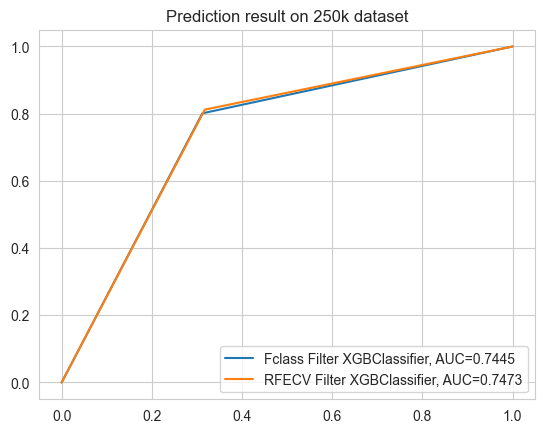

In [53]:

y_pred = best_model_fclass.predict(x_test_fclass)
fpr, tpr, _ = roc_curve(df_y_test, y_pred)
auc = round(roc_auc_score(df_y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Fclass Filter XGBClassifier, AUC="+str(auc))

#fit gradient boosted model and plot ROC curve

y_pred = best_model_RFECV.predict(x_test_rfecv)
fpr, tpr, _ = roc_curve(df_y_test, y_pred)
auc = round(roc_auc_score(df_y_test, y_pred), 4)
plt.plot(fpr,tpr,label="RFECV Filter XGBClassifier, AUC="+str(auc))
plt.legend()
plt.title('Prediction result on 250k dataset')